# <font color='steelblue'>
______________________________________________________________________________________________________________________________________________________
### <center> <font color='steelblue'> Post-graduation in Data Science for Finance
##### <center> <font color='steelblue'> 2024 / 25
# <center> <font color='steelblue'> Fixed Income Securities
### <center> <font color='steelblue'><font> Prof. Jorge Bravo </font>
______________________________________________________________________________________________________________________________________________________
### <center> <font color='steelblue'><font> Students:</font>
##### <center> <font color='steelblue'><font> Diogo Rodrigues, 20211666 </font>
##### <center> <font color='steelblue'><font> Gonçalo Gomes, 20211007 </font>
##### <center> <font color='steelblue'><font> Petr Terletskiy, 20211580 </font>
##### <center> <font color='steelblue'><font> Tiago Paulino, 20211601 </font>

______________________________________________________________________________________________________________________________________________________
### <center> <font color='steelblue'><font> Group Project </font>
______________________________________________________________________________________________________________________________________________________


# 0. Libraries

In [ ]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize, linprog
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns

from google.colab import drive

# 1. Bonds

In [ ]:
# Dataset for the problem
maturities = np.array([0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0])
coupon_rates = np.array([0.50, 0.75, 1.00, 1.25, 1.50, 1.70, 1.80, 2.00, 2.25, 2.50]) / 100
bond_prices = np.array([98.00, 98.50, 100.00, 99.50, 99.00, 100.50, 101.00, 101.00, 101.50, 100.50])
yield_volatilities = np.array([3.50, 3.40, 3.30, 3.15, 3.00, 2.80, 2.60, 2.40, 2.20, 2.00]) / 100

face_value = 100  # Face value of each bond
freq = 2  # Semi-annual coupon payments

## a) Bootstrap spot rate curve

In [ ]:
#Spot rate calculation
spot_rates = []
for i in range(len(maturities)):
    maturity = maturities[i]
    coupon = coupon_rates[i] * face_value / freq
    price = bond_prices[i]

    if i == 0:  # First bond, zero-coupon equivalent
        spot_rate = -np.log(price / face_value) / maturity
    else:
        cash_flows = np.array([coupon] * int(maturity * freq))
        cash_flows[-1] += face_value
        time_points = np.array([(j + 1) / freq for j in range(len(cash_flows))])

        # Solve for spot rate
        def bond_price_error(rate):
            discount_factors = np.exp(-rate * time_points)
            return np.sum(cash_flows * discount_factors) - price

        from scipy.optimize import root_scalar
        result = root_scalar(bond_price_error, bracket=[0, 1], method='brentq')
        spot_rate = result.root

    spot_rates.append(spot_rate*100)

spot_rates = np.array(spot_rates)

dfa = pd.DataFrame({'Maturity': maturities, 'Spot Rates': spot_rates})
dfa

,Maturity,Spot Rates
0,0.5,4.040541
1,1.0,2.262800
2,1.5,0.997508
3,2.0,1.499088
4,2.5,1.902465
5,3.0,1.523032
6,3.5,1.499979
7,4.0,1.732587
8,4.5,1.891654
9,5.0,2.379095


## b) Estimate bond volatility

In [ ]:
# Calculate Bond Volatility
bond_volatilities = yield_volatilities * np.sqrt(maturities)

dfb = pd.DataFrame({'Maturity': maturities, 'Bond Volatility': bond_volatilities*100})
dfb

,Maturity,Bond Volatility
0,0.5,2.474874
1,1.0,3.400000
2,1.5,4.041658
3,2.0,4.454773
4,2.5,4.743416
5,3.0,4.849742
6,3.5,4.864155
7,4.0,4.800000
8,4.5,4.666905
9,5.0,4.472136


## c) Fair price of a 5-year corporate bond

In [ ]:
# Bond parameters
face_value = 100000
coupon_rate = 0.03
credit_spread = 0.01
corporate_maturity = 5
freq = 2
coupon_payment = face_value * coupon_rate / freq

# Cash flows
corporate_cash_flows = np.array([coupon_payment] * int(corporate_maturity * freq))
corporate_cash_flows[-1] += face_value
corporate_time_points = np.array([(j + 1) / freq for j in range(len(corporate_cash_flows))])

# Adjusted spot rates and discount factors
adjusted_spot_rates = spot_rates + credit_spread
corporate_discount_factors = np.exp(-adjusted_spot_rates[:len(corporate_cash_flows)] * corporate_time_points)

# Calculate bond price
corporate_price = np.sum(corporate_cash_flows * corporate_discount_factors)

# Calculate Macaulay duration
duration = np.sum(corporate_time_points * corporate_cash_flows * corporate_discount_factors) / corporate_price

# Calculate convexity
convexity = np.sum(corporate_time_points * (corporate_time_points + 1) * corporate_cash_flows * corporate_discount_factors) / corporate_price

# Display results
print(f"Corporate Bond Price: ${corporate_price:,.2f}")
print(f"Duration: {duration:.2f} years")
print(f"Convexity: {convexity:.2f}")

Corporate Bond Price: $97,836.00
Duration: 4.67 years
Convexity: 27.43


#2. Spot Rates

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


###a) Fit Nelson-Siegel

In [ ]:
# Defining the Nelson-Siegel function

def nelson_siegel(beta, tau, maturity):
  beta0, beta1, beta2 = beta
  term1 = beta0
  term2 = beta1 * ((1 - np.exp(-maturity / tau)) / (maturity / tau))
  term3 = beta2 * (((1 - np.exp(-maturity / tau)) / (maturity / tau)) - np.exp(-maturity / tau))
  return term1 + term2 + term3

# Defining the objective function (MSE) to minimize

def objective_function(params, maturity, rates):
  # B0, B1 and B1 parameters

  beta = params[:3]

  # Tau Parameter

  tau = params[3]
  fitted_rates = nelson_siegel(beta, tau, maturity)
  mse = np.mean((rates - fitted_rates) ** 2)
  return mse
# Loading the dataset

file_path = '/content/drive/MyDrive/Nova Ims/Fixed Income Securities/Yield_data.xlsx'
yield_curve_data = pd.read_excel(file_path, sheet_name='Yield_Curve')

# Extracting the maturities and preparing the dataset for fitting

maturities = yield_curve_data.columns[1:].astype(float).values
dates = yield_curve_data['Date']

# Extracting the spot rates

spot_rates = yield_curve_data.iloc[:, 1:].values

# Initialize results list

results = []

# Fitting the model for each provided date

for i, date in enumerate(dates):

    rates = spot_rates[i, :]

    # Initial guesses for [beta0, beta1, beta2, tau]

    initial_params = [np.mean(rates), -0.02, 0.02, 2.0]
    bounds = [(None, None), (None, None), (None, None), (0.1, None)]
    # Minimizing the objective function

    result = minimize(objective_function, initial_params, args=(maturities, rates), bounds=bounds)

    # Store results: date, beta0, beta1, beta2, tau, mse

    beta0, beta1, beta2, tau = result.x
    mse = result.fun
    results.append([date, beta0, beta1, beta2, tau, mse])

# Converting the results to a Pandas DataFrame

ns_results = pd.DataFrame(results, columns=['Date', 'Beta0', 'Beta1', 'Beta2', 'Tau', 'MSE'])
ns_results.set_index("Date", inplace = True)
print(ns_results.head())

               Beta0     Beta1     Beta2       Tau       MSE
Date                                                        
2005-01-31  5.187177 -2.741540 -2.488813  1.636429  0.003642
2005-02-28  5.205753 -2.718676 -2.487397  1.541037  0.003966
2005-03-31  5.086861 -2.572039 -1.379010  1.725137  0.004004
2005-04-29  4.989216 -2.547923 -1.620650  1.781286  0.004336
2005-05-31  4.768142 -2.331762 -1.901424  1.731375  0.003888


###b) Yield Curve Dynamics

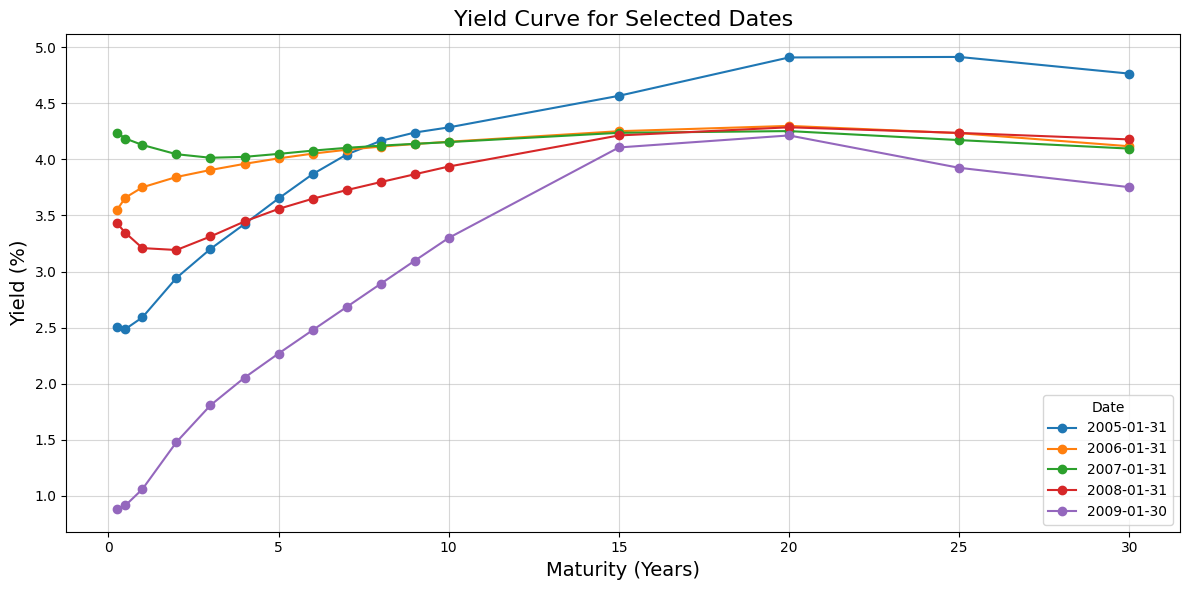

In [ ]:
# Choosing one date per year for the first five years to include in the visualization

selected_dates = yield_curve_data['Date'].iloc[[0, 12, 24, 36, 48]]

# Filtering the data for the selected dates

filtered_data = yield_curve_data[yield_curve_data['Date'].isin(selected_dates)]

# Plotting the yield curves

plt.figure(figsize=(12, 6))

for _, row in filtered_data.iterrows():
    plt.plot(maturities, row.iloc[1:], marker='o', label=row['Date'].strftime('%Y-%m-%d'))

# Configuring the Plot

plt.title('Yield Curve for Selected Dates', fontsize=16)
plt.xlabel('Maturity (Years)', fontsize=14)
plt.ylabel('Yield (%)', fontsize=14)
plt.legend(title='Date', fontsize=10)
plt.grid(alpha=0.5)
plt.tight_layout()

plt.show()

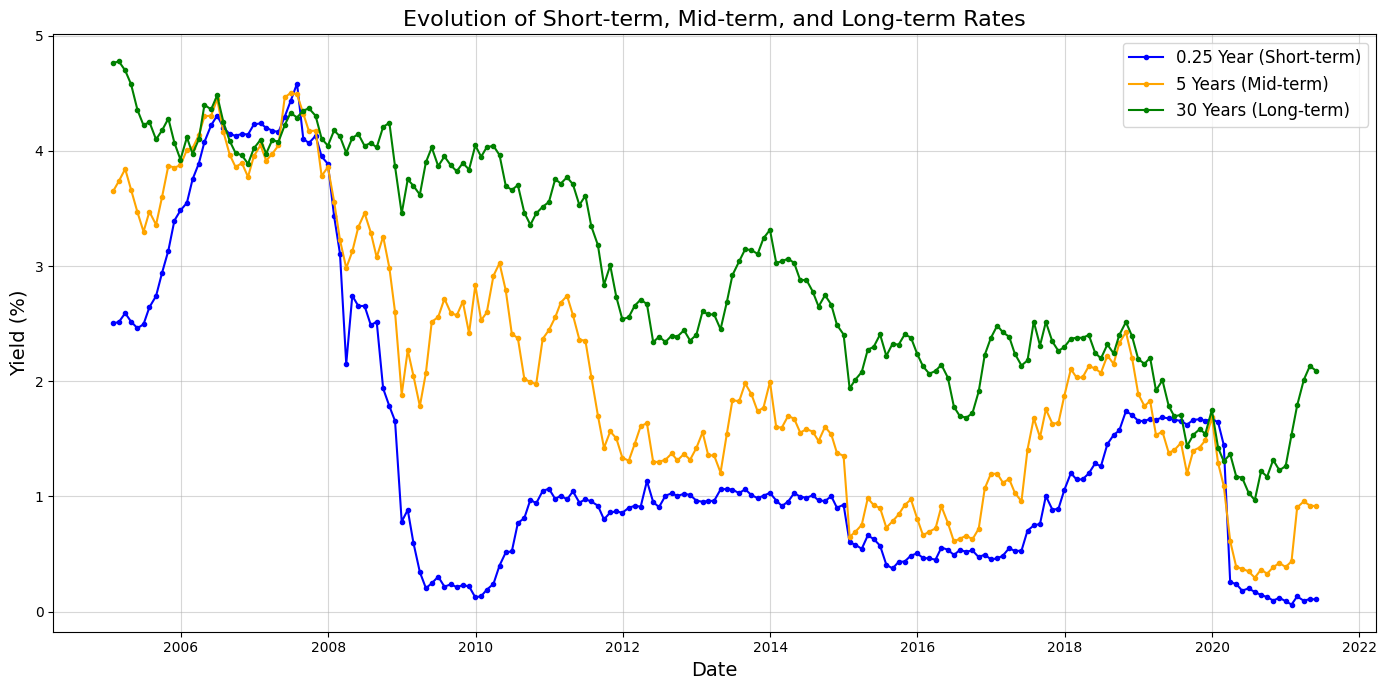

In [ ]:
# Selecting maturities for short-term, mid-term, and long-term analysis (3 months, 5 years and 30 years)

short_term_maturity = 0.25
mid_term_maturity = 5
long_term_maturity = 30

# Extracting the rates for the selected maturities

short_term_rates = yield_curve_data[short_term_maturity]
mid_term_rates = yield_curve_data[mid_term_maturity]
long_term_rates = yield_curve_data[long_term_maturity]

# Plotting the evolution of the rates over time

plt.figure(figsize=(14, 7))

plt.plot(yield_curve_data['Date'], short_term_rates, label=f'{short_term_maturity} Year (Short-term)', color='blue', marker='.')
plt.plot(yield_curve_data['Date'], mid_term_rates, label=f'{mid_term_maturity} Years (Mid-term)', color='orange', marker='.')
plt.plot(yield_curve_data['Date'], long_term_rates, label=f'{long_term_maturity} Years (Long-term)', color='green', marker='.')

# Configuring the plot

plt.title('Evolution of Short-term, Mid-term, and Long-term Rates', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Yield (%)', fontsize=14)
plt.legend(fontsize=12)
plt.grid(alpha=0.5)
plt.tight_layout()

plt.show()

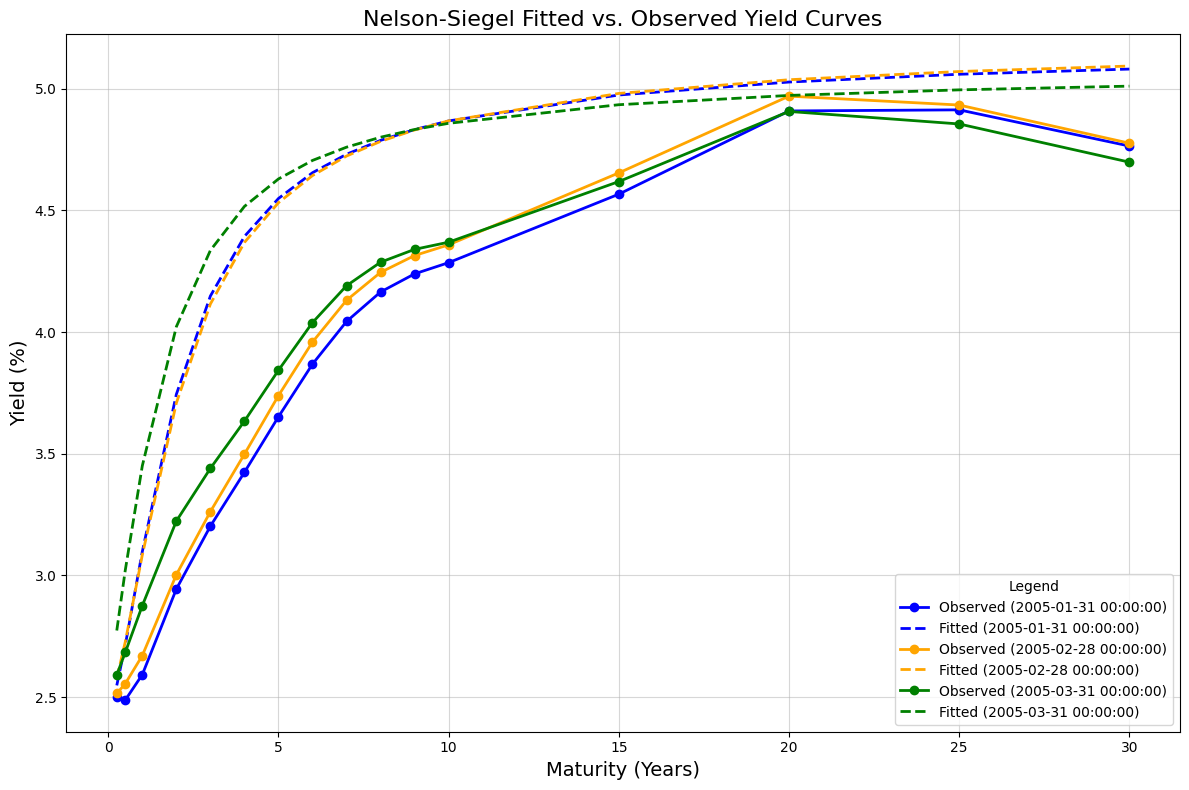

In [ ]:
# Reconstructing the Nelson-Siegel function

def nelson_siegel(tau, beta0, beta1, beta2, lambd):

    term1 = beta0
    term2 = beta1 * (1 - np.exp(-lambd * tau)) / (lambd * tau)
    term3 = beta2 * ((1 - np.exp(-lambd * tau)) / (lambd * tau) - np.exp(-lambd * tau))

    return term1 + term2 + term3

# Defining maturities from yield curve columns

maturities = yield_curve_data.columns[1:].astype(float)

# Selecting dates for visualization --> Using only the first three dates

selected_dates = ns_results.index[:3]

# Creating the visualization and taking into account the fitted vs observed color pais

plt.figure(figsize=(12, 8))
colors = ['blue', 'orange', 'green']

for i, date in enumerate(selected_dates):

    # Real yields for the given date

    observed_yields = yield_curve_data.loc[yield_curve_data['Date'] == date].iloc[0, 1:].values

    # Fitted yields using Nelson-Siegel function and parameters

    params = ns_results.loc[date]
    fitted_yields = nelson_siegel(maturities, params['Beta0'], params['Beta1'], params['Beta2'], params['Tau'])

    # Plotting the observed and fitted yields
    plt.plot(maturities, observed_yields, 'o-', color=colors[i], label=f'Observed ({date})', linewidth=2)
    plt.plot(maturities, fitted_yields, '--', color=colors[i], label=f'Fitted ({date})', linewidth=2)

# Plot Configuration

plt.title('Nelson-Siegel Fitted vs. Observed Yield Curves', fontsize=16)
plt.xlabel('Maturity (Years)', fontsize=14)
plt.ylabel('Yield (%)', fontsize=14)
plt.legend(fontsize=10, title='Legend')
plt.grid(alpha=0.5)
plt.tight_layout()

plt.show()

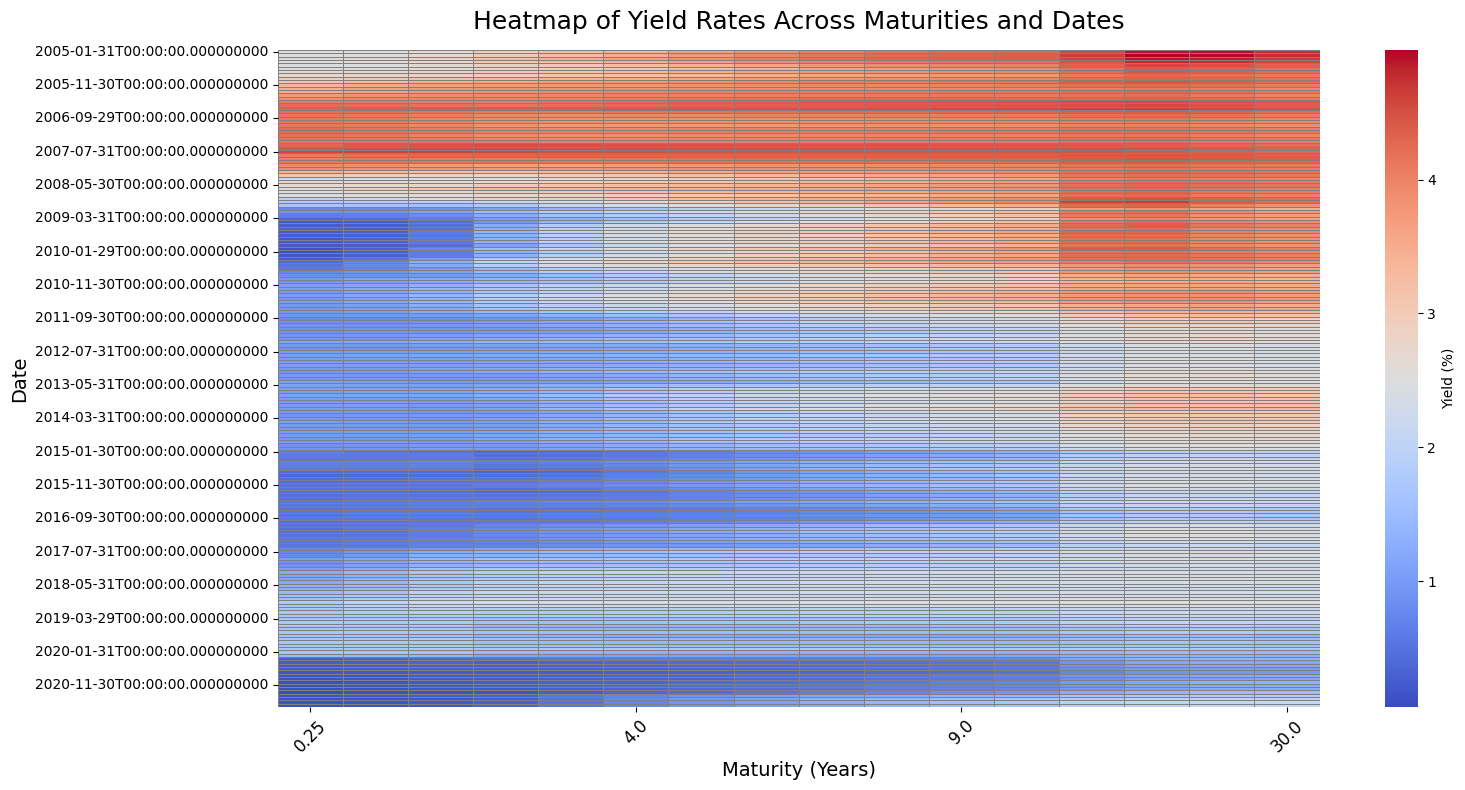

In [ ]:
# Preparing the data for the heatmap --> pivot table to have maturities as columns and dates as rows

maturities = yield_curve_data.columns[1:].astype(float)
heatmap_data = yield_curve_data.set_index('Date')
heatmap_data.columns = maturities

# Creating the Heatmap

plt.figure(figsize=(16, 8))

sns.heatmap(
    heatmap_data,
    cmap="coolwarm",
    cbar_kws={'label': 'Yield (%)'},
    xticklabels=5,
    yticklabels=10,
    annot=False,
    linewidths=0.5,
    linecolor='gray'
)

# Plot Configuration

plt.title('Heatmap of Yield Rates Across Maturities and Dates', fontsize=18, pad=15)
plt.xlabel('Maturity (Years)', fontsize=14)
plt.ylabel('Date', fontsize=14)
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=10)
plt.tight_layout()

plt.show()

###c) Yield Curve Dynamics

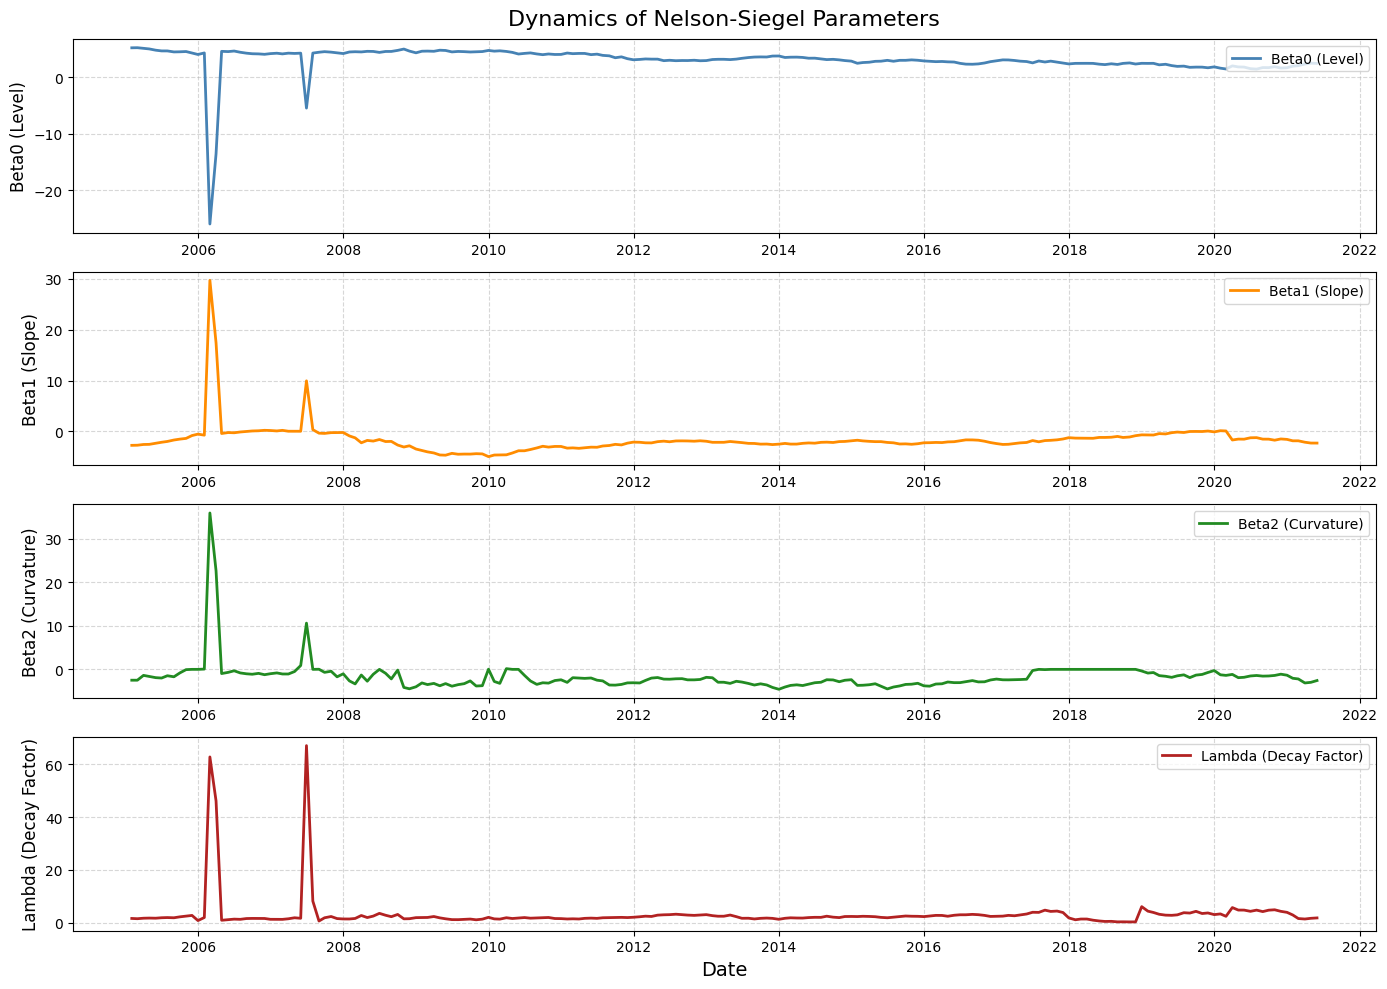

In [ ]:
# Converting the index to datetime

ns_results.index = pd.to_datetime(ns_results.index)

# Trying to visualize the dynamics of Nelson-Siegel parameters

plt.figure(figsize=(14, 10))

# Beta0 (Level)

plt.subplot(4, 1, 1)

plt.plot(ns_results.index, ns_results['Beta0'], label='Beta0 (Level)', color='steelblue', linewidth=2)
plt.title('Dynamics of Nelson-Siegel Parameters', fontsize=16, pad=10)
plt.ylabel('Beta0 (Level)', fontsize=12)
plt.grid(alpha=0.5, linestyle='--')
plt.legend(fontsize=10, loc='upper right')

# Beta1 (Slope)

plt.subplot(4, 1, 2)

plt.plot(ns_results.index, ns_results['Beta1'], label='Beta1 (Slope)', color='darkorange', linewidth=2)
plt.ylabel('Beta1 (Slope)', fontsize=12)
plt.grid(alpha=0.5, linestyle='--')
plt.legend(fontsize=10, loc='upper right')

# Beta2 (Curvature)

plt.subplot(4, 1, 3)

plt.plot(ns_results.index, ns_results['Beta2'], label='Beta2 (Curvature)', color='forestgreen', linewidth=2)
plt.ylabel('Beta2 (Curvature)', fontsize=12)
plt.grid(alpha=0.5, linestyle='--')
plt.legend(fontsize=10, loc='upper right')

# Lambda (Decay Factor)

plt.subplot(4, 1, 4)

plt.plot(ns_results.index, ns_results['Tau'], label='Lambda (Decay Factor)', color='firebrick', linewidth=2)
plt.ylabel('Lambda (Decay Factor)', fontsize=12)
plt.xlabel('Date', fontsize=14)
plt.grid(alpha=0.5, linestyle='--')
plt.legend(fontsize=10, loc='upper right')

plt.tight_layout()
plt.show()

In [ ]:
# Extracting the maturities and preparing the dataset for the descriptive analysis

ns_results = pd.DataFrame(
    results, columns=['Date', 'Beta0', 'Beta1', 'Beta2', 'Tau', 'MSE']
)

# Converting Date to datetime format

ns_results['Date'] = pd.to_datetime(ns_results['Date'])

# Analyzing the dynamics of the Nelson-Siegel function parameters

for param in ['Beta0', 'Beta1', 'Beta2', 'Tau']:
    print(f"Analysis of {param}:")
    print(f"Mean: {ns_results[param].mean()}")
    print(f"Standard Deviation: {ns_results[param].std()}")
    print(f"Minimum: {ns_results[param].min()} on {ns_results.loc[ns_results[param].idxmin(), 'Date']}")
    print(f"Maximum: {ns_results[param].max()} on {ns_results.loc[ns_results[param].idxmax(), 'Date']}")
    print("\n")

Analysis of Beta0:
Mean: 3.07712349824729
Standard Deviation: 2.6628047262840164
Minimum: -25.912366915927834 on 2006-02-28 00:00:00
Maximum: 5.205753255596178 on 2005-02-28 00:00:00


Analysis of Beta1:
Mean: -1.6197008680828284
Standard Deviation: 3.00997364872325
Minimum: -4.962689820786153 on 2009-12-31 00:00:00
Maximum: 29.72174222451893 on 2006-02-28 00:00:00


Analysis of Beta2:
Mean: -1.6419923631147368
Standard Deviation: 3.5743811296128496
Minimum: -4.56893088988817 on 2013-12-31 00:00:00
Maximum: 35.89453126210221 on 2006-02-28 00:00:00


Analysis of Tau:
Mean: 3.198822788680941
Standard Deviation: 7.0935218724144775
Minimum: 0.3283166993186021 on 2018-10-31 00:00:00
Maximum: 67.08855126479929 on 2007-06-29 00:00:00




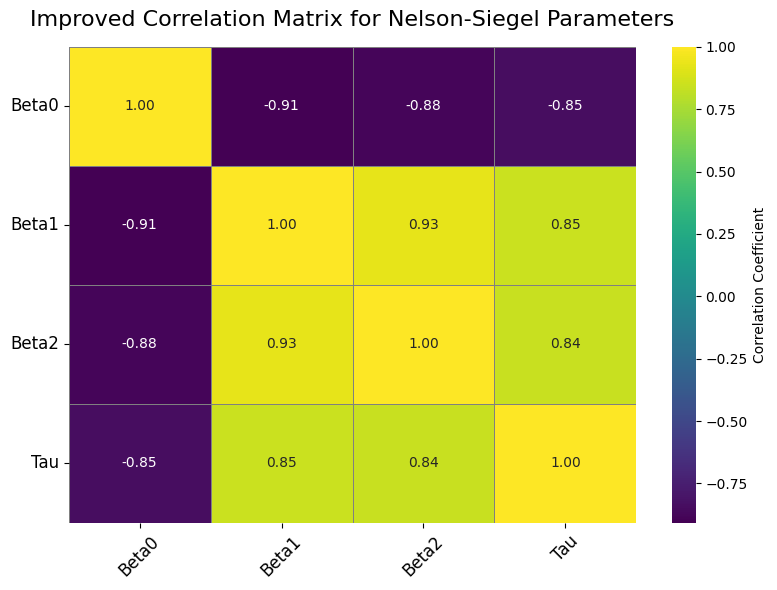

In [ ]:
# Pearson Correlation Matrix

correlation_matrix = ns_results[['Beta0', 'Beta1', 'Beta2', 'Tau']].corr()

plt.figure(figsize=(8, 6))

sns.heatmap(
    correlation_matrix,
    annot=True,
    fmt=".2f",
    cmap="viridis",
    cbar_kws={'label': 'Correlation Coefficient'},
    linewidths=0.5,
    linecolor='gray'
)
plt.title('Improved Correlation Matrix for Nelson-Siegel Parameters', fontsize=16, pad=15)
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12, rotation=0)
plt.tight_layout()

plt.show()

#3. Treasury Bonds

In [ ]:
# Data for the Part III

# Portfolio of fixed-rate Treasury bonds
bonds_data = {
    'Bond': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13],
    'Maturity': pd.to_datetime(['2025-12-01', '2026-12-04', '2027-12-06', '2028-12-10', '2029-12-03', '2030-12-09',
                                '2032-12-06', '2035-12-03', '2030-12-03', '2045-12-04', '2050-12-04', '2051-12-01', '2052-12-07']),
    'Coupon Rate (%)': [4, 7.75, 4, 7, 5.75, 5.5, 4, 4.75, 4.5, 5, 4.5, 4, 5],
    'Quantity': [10000, 250000, 50000, 100000, 10000, 200000, 15000, 10000, 30000, 75000, 100000, 10000, 10000],
    'Face Value': [100] * 13
}

# NSS parameters on 09/02/2022
yield_curve_params = {"Beta0": 5.9 / 100, "Beta1": -1.6 / 100, "Beta2": -0.5 / 100, "Beta3": 1.0 / 100, "Tau1": 5, "Tau2": 0.5}

# Hedging instruments
hedging_assets_data = {
    'Hedging Asset': ['H1', 'H2', 'H3', 'H4', 'H5'],
    'Coupon Rate (%)': [4.5, 5, 6, 6, 6.5],
    'Maturity': pd.to_datetime(['2026-04-12', '2032-12-28', '2035-05-06', '2040-10-10', '2051-10-10']),
    'Face Value': [100] * 5}

portfolio_df, hedging_df = pd.DataFrame(bonds_data), pd.DataFrame(hedging_assets_data)

### Functions

In [ ]:
# Functions for NSS model and durations

# function to compute the Nelson-Siegel-Svensson (NSS) yield curve model
def nss_yield(beta_0, beta_1, beta_2, beta_3, tau_1, tau_2, t):
    term1 = beta_0
    term2 = beta_1 * (1 - np.exp(-t / tau_1)) / (t / tau_1)
    term3 = beta_2 * ((1 - np.exp(-t / tau_1)) / (t / tau_1) - np.exp(-t / tau_1))
    term4 = beta_3 * ((1 - np.exp(-t / tau_2)) / (t / tau_2) - np.exp(-t / tau_2))
    return term1 + term2 + term3 + term4

# function to generate cash flows for a bond
def bond_cash_flows(face_value, coupon_rate, years, maturity_years):
    cash_flows = [face_value * coupon_rate / 100] * (maturity_years - years)
    cash_flows[-1] += face_value
    return cash_flows

# function to compute the Macaulay duration and other bond portfolio metrics
def calculate_durations(portfolio_df, valuation_date, bond_id_col='Bond'):
    portfolio_df = portfolio_df.copy()
    portfolio_df["Years_to_Maturity"] = (portfolio_df["Maturity"] - valuation_date).dt.days / 365.25

    portfolio_results = []
    for _, row in portfolio_df.iterrows():
        bond_maturity = row["Years_to_Maturity"]
        coupon_rate = row["Coupon Rate (%)"]
        quantity = row.get("Quantity", 1)
        face_value = row["Face Value"]

        cash_flows = bond_cash_flows(face_value, coupon_rate, 0, int(bond_maturity))
        times = np.arange(1, len(cash_flows) + 1)

        yields = nss_yield(
            yield_curve_params["Beta0"], yield_curve_params["Beta1"], yield_curve_params["Beta2"],
            yield_curve_params["Beta3"], yield_curve_params["Tau1"], yield_curve_params["Tau2"], times
        )
        discount_factors = np.exp(-yields * times)
        pv_cash_flows = np.sum(np.array(cash_flows) * discount_factors)
        weighted_cash_flow_times = np.sum(times * np.array(cash_flows) * discount_factors)
        macaulay_duration = weighted_cash_flow_times / pv_cash_flows

        portfolio_results.append({
            bond_id_col: row[bond_id_col],
            "Maturity": row["Maturity"],
            "Years_to_Maturity": bond_maturity,
            "PV_Cash_Flows": pv_cash_flows,
            "Macaulay_Duration": macaulay_duration,
        })

    df_results = pd.DataFrame(portfolio_results)
    total_pv = df_results["PV_Cash_Flows"].sum()
    portfolio_duration = (df_results["Macaulay_Duration"] * df_results["PV_Cash_Flows"]).sum() / total_pv
    df_results["Dollar_Duration"] = df_results["Macaulay_Duration"] * df_results["PV_Cash_Flows"]
    total_dollar_duration = df_results["Dollar_Duration"].sum()

    return df_results, portfolio_duration, total_dollar_duration

### a) Compute target portfolio

In [ ]:
# task a)
valuation_date = datetime(2022, 9, 2)
target_results, target_duration, target_dollar_duration = calculate_durations(portfolio_df, valuation_date)

# results
print("\n=== Target Portfolio Results ===\n")
print(target_results.to_string(index=False, float_format='{:,.4f}'.format))

print("\n\n\n=== Portfolio Metrics ===\n")
print(f"Target Portfolio Duration (years): {target_duration:.4f}")
print(f"Total Dollar Duration of Target Portfolio: {target_dollar_duration:,.2f}")


=== Target Portfolio Results ===

 Bond   Maturity  Years_to_Maturity  PV_Cash_Flows  Macaulay_Duration  Dollar_Duration
    1 2025-12-01             3.2471        97.6182             2.8845         281.5832
    2 2026-12-04             4.2546       110.0765             3.6094         397.3047
    3 2027-12-06             5.2594        95.8024             4.6199         442.5941
    4 2028-12-10             6.2724       110.0741             5.1450         566.3313
    5 2029-12-03             7.2526       103.9449             5.9750         621.0673
    6 2030-12-09             8.2683       102.4821             6.6947         686.0891
    7 2032-12-06            10.2615        90.7703             8.3308         756.1940
    8 2035-12-03            13.2512        94.8812             9.8644         935.9490
    9 2030-12-03             8.2519        96.0211             6.8602         658.7225
   10 2045-12-04            23.2553        93.6216            13.6910       1,281.7715
   11 20

### b) Compute hedging portfolio

In [ ]:
# task b)
valuation_date = datetime(2022, 9, 2)
hedging_results, hedging_duration, hedging_dollar_duration = calculate_durations(hedging_df, valuation_date, bond_id_col='Hedging Asset')

# results
print("\n=== Hedging Assets Results ===\n")
print(hedging_results.to_string(index=False, float_format='{:,.4f}'.format))

print("\n\n\n=== Hedging Portfolio Metrics ===\n")
print(f"Hedging Portfolio Duration (years): {hedging_duration:.4f}")
print(f"Total Dollar Duration of Hedging Portfolio: {hedging_dollar_duration:,.2f}")


=== Hedging Assets Results ===

Hedging Asset   Maturity  Years_to_Maturity  PV_Cash_Flows  Macaulay_Duration  Dollar_Duration
           H1 2026-04-12             3.6085        98.9835             2.8719         284.2704
           H2 2032-12-28            10.3217        98.4652             8.0766         795.2652
           H3 2035-05-06            12.6735       106.4265             8.9650         954.1113
           H4 2040-10-10            18.1054       106.6845            11.6062       1,238.1979
           H5 2051-10-10            29.1034       113.8175            14.3625       1,634.7013



=== Hedging Portfolio Metrics ===

Hedging Portfolio Duration (years): 9.3569
Total Dollar Duration of Hedging Portfolio: 4,906.55


### c) Estimate holdings hedging portfolio

In [ ]:
# Function to optimize hedging portfolio
def optimize_hedging(target_dollar_duration, target_pv, hedging_results):
    hedging_dollar_durations = hedging_results["Dollar_Duration"].values
    hedging_pvs = hedging_results["PV_Cash_Flows"].values

    # set up the optimization problem
    c = hedging_pvs  # Objective: minimize total cost of hedging portfolio
    A_eq = [hedging_dollar_durations, hedging_pvs]  # Constraints: match dollar duration and total value
    b_eq = [target_dollar_duration, target_pv]  # match target dollar duration and present value

    # bounds for weights (holdings of hedging assets)
    bounds = [(0, None) for _ in hedging_dollar_durations]

    # solve the linear programming problem and extract the solution
    result = linprog(c, A_eq=A_eq, b_eq=b_eq, bounds=bounds, method="highs")
    hedging_weights = result.x
    hedging_portfolio_cost = result.fun

    # results
    hedging_portfolio = pd.DataFrame({
        "Hedging_Asset": hedging_results["Bond"],
        "Dollar_Duration": hedging_dollar_durations,
        "Present_Value": hedging_pvs,
        "Weight": hedging_weights,
        "Holding": hedging_weights / hedging_pvs,
    })

    return hedging_portfolio, hedging_portfolio_cost

In [ ]:
# Task c)
hedging_results = pd.DataFrame({
    "Bond": ["H1", "H2", "H3", "H4", "H5"],
    "Dollar_Duration": [1000, 2000, 1500, 2500, 3000],
    "PV_Cash_Flows": [950, 1800, 1400, 2400, 2900]
})

target_dollar_duration, target_pv = 10500, 10000

# optimize the hedging portfolio
hedging_portfolio, hedging_cost = optimize_hedging(target_dollar_duration, target_pv, hedging_results)

# results
print("\n=== Hedging Portfolio Optimization Results ===\n")
print(hedging_portfolio.to_string(index=False, float_format='{:,.4f}'.format))

print("\n\n\n=== Hedging Portfolio Metrics ===\n")
print(f"Total Hedging Portfolio Cost: {hedging_cost:,.2f}")


=== Hedging Portfolio Optimization Results ===

Hedging_Asset  Dollar_Duration  Present_Value  Weight  Holding
           H1             1000            950  0.0000   0.0000
           H2             2000           1800  1.1250   0.0006
           H3             1500           1400  0.0000   0.0000
           H4             2500           2400  0.0000   0.0000
           H5             3000           2900  2.7500   0.0009



=== Hedging Portfolio Metrics ===

Total Hedging Portfolio Cost: 10,000.00


### d) Impacts


In [ ]:
# New NSS Parameters after yield curve change
nss_params_changed = {"beta_0": 6.5 / 100, "beta_1": -1.0 / 100, "beta_2": 0.1 / 100, "beta_3": 2.0 / 100, "tau_1": 5, "tau_2": 0.5}

# Function to compute yield based on NSS model
def nss_yield(beta_0, beta_1, beta_2, beta_3, tau_1, tau_2, t):
    term1 = beta_0
    term2 = beta_1 * (1 - np.exp(-t / tau_1)) / (t / tau_1)
    term3 = beta_2 * ((1 - np.exp(-t / tau_1)) / (t / tau_1) - np.exp(-t / tau_1))
    term4 = beta_3 * ((1 - np.exp(-t / tau_2)) / (t / tau_2) - np.exp(-t / tau_2))
    return term1 + term2 + term3 + term4

# Function to estimate the impact of the yield curve shift
def estimate_impact(portfolio, nss_params):
    impact = []

    for _, row in portfolio.iterrows():
        maturity = row["Maturity"]
        dollar_duration = row["Dollar_Duration"]

        new_yield = nss_yield(
            nss_params["beta_0"], nss_params["beta_1"], nss_params["beta_2"],
            nss_params["beta_3"], nss_params["tau_1"], nss_params["tau_2"], maturity
        )

        impact_on_bond = -dollar_duration * new_yield
        impact.append(impact_on_bond)

    portfolio["Impact"] = impact
    total_impact = portfolio["Impact"].sum()

    return portfolio, total_impact

##### i. & ii.

In [ ]:
# Task d)
target_portfolio = pd.DataFrame({
    "Bond": ["B1", "B2", "B3", "B4", "B5"],
    "Maturity": [1, 3, 5, 10, 30],
    "Dollar_Duration": [500, 1500, 2500, 4000, 8000]
})

# Estimate impact on target portfolio
target_portfolio, target_total_impact = estimate_impact(target_portfolio, nss_params_changed)

hedging_portfolio = pd.DataFrame({
    "Hedging_Asset": ["H1", "H2", "H3", "H4", "H5"],
    "Maturity": [2, 4, 6, 10, 20],
    "Dollar_Duration": [1000, 2000, 1500, 3000, 3500]
})

# estimate impact on hedging portfolio
hedging_portfolio, hedging_total_impact = estimate_impact(hedging_portfolio, nss_params_changed)

# global impact (target + hedging)
global_total_impact = target_total_impact + hedging_total_impact

# results
print("\n=== Impact on Target Portfolio ===\n")
print(target_portfolio.to_string(index=False, float_format='{:,.4f}'.format))
print("\n\n=== Target Portfolio Metrics ===\n")
print(f"Total Impact on Target Portfolio: {target_total_impact:,.2f}")
print("\n===================================================")
print("===================================================\n")

print("=== Impact on Hedging Portfolio ===\n")
print(hedging_portfolio.to_string(index=False, float_format='{:,.4f}'.format))
print("\n\n=== Hedging Portfolio Metrics ===\n")
print(f"Total Impact on Hedging Portfolio: {hedging_total_impact:,.2f}")

print("\n\n===================================================")
print("===================================================\n")
print(f"Global Total Impact (Target + Hedging):  {global_total_impact:,.2f}")


=== Impact on Target Portfolio ===

Bond  Maturity  Dollar_Duration    Impact
  B1         1              500  -30.9820
  B2         3             1500  -91.4383
  B3         5             2500 -152.3551
  B4        10             4000 -247.8947
  B5        30             8000 -510.6766


=== Target Portfolio Metrics ===

Total Impact on Target Portfolio: -1,033.35


=== Impact on Hedging Portfolio ===

Hedging_Asset  Maturity  Dollar_Duration    Impact
           H1         2             1000  -61.4540
           H2         4             2000 -121.6961
           H3         6             1500  -91.6864
           H4        10             3000 -185.9210
           H5        20             3500 -221.4551


=== Hedging Portfolio Metrics ===

Total Impact on Hedging Portfolio: -682.21



Global Total Impact (Target + Hedging):  -1,715.56
